In [1]:
import os
os.environ['HF_HOME'] = '<PATH_TO>/hf_cache'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import torch
import torch.nn as nn
import gymnasium
import sys
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import colorama
import re
import copy
import numpy as np

from thefuzz import fuzz, process
from string import punctuation

rocket_dir = os.path.split(os.path.abspath(os.curdir))[:-1]
rocket_src_dir = os.path.join(*rocket_dir, 'src')
rocket_dir = os.path.join(*rocket_dir)

print(f'Appending to sys.path:', [rocket_dir, rocket_src_dir])

sys.path.append(rocket_dir)
sys.path.append(rocket_src_dir)

from PIL import Image
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoConfig,
    AutoProcessor,
    Idefics2ForConditionalGeneration
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

from torch.distributions.categorical import Categorical
from accelerate import Accelerator

from agents.base_agent import BaseAgent
from src.environments.frozen_env import make_frozen_env
from src.environments.minigrid_env import make_minigrid_env
#from src.agents.IDEFICS_agent import IDEFICSAgent

accelerator = Accelerator()

pygame 2.5.2 (SDL 2.28.2, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Appending to sys.path: ['/mnt/llmdata/home/gbonetta/progetti/rocket', '/mnt/llmdata/home/gbonetta/progetti/rocket/src']


/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment FrozenLakeText-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment Hanoi3Disk-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment Hanoi4Disk-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [3]:
# env_id = "FrozenLakeText-v0"
env_id = "MiniGrid-LavaGapS7-v0"

first_person = True

possible_action_list = "forward opt_back opt_left opt_right"
seed = 42

In [4]:
if 'frozen' in env_id.lower():
      envs = gymnasium.vector.SyncVectorEnv([
          make_frozen_env(
              "run_dir_prova",
              area=8,
              fov=1,
              seed=seed,
              size=400,
              is_slippery=False,
              fixed_orientation=False,
              save_video=False,
              save_stats=True,
              first_person=first_person)
        for i in range(2) ])
else:
    envs = gymnasium.vector.SyncVectorEnv([
        make_minigrid_env(
            "run_dir_prova",
            env_id,
            possible_actions_list=possible_action_list.split(),
            fov=1,
            fixed_orientation=False,
            no_step_description=False,
            seed=seed,
            history_size=0,
            save_video=False,
            save_stats=False,
            first_person=first_person)
        for i in range(2) ])
    
observation_space = envs.single_observation_space
action_enum = envs.envs[0].action_enum
list(action_enum)

/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(


[<action_enum.forward: 'move forward'>,
 <action_enum.opt_left: 'move left'>,
 <action_enum.opt_right: 'move right'>,
 <action_enum.opt_back: 'move back'>]

In [5]:

class Idefics2Agent(nn.Module, BaseAgent):
    def __init__(
        self, checkpoint_name, action_enum, is_lora=False, padding_side="right", num_prompt_images=1, use_text_description=True, gradient_ckpt=False, disable_adapters_for_generation=True, max_new_tokens=100
    ):
        super().__init__()
        self.action_enum = action_enum
        self.action_generation_cache = {}
        self.disable_adapters_for_generation = disable_adapters_for_generation
        self.is_lora = is_lora
        self.num_prompt_images = num_prompt_images
        self.use_text_description = use_text_description
        self.max_new_tokens = max_new_tokens
        self.network, self.processor, self.config = self._load_model(
            checkpoint_name, is_lora, padding_side, gradient_ckpt
        )
        # the critic remains in float32. (i.e. no lora or quantized stuff)
        self.critic = nn.Sequential(
            nn.Linear(self.config.text_config.hidden_size, 1024),  # Input layer
            nn.ReLU(),  # ReLU activation function
            nn.Linear(1024, 512),  # Hidden layer 1
            nn.ReLU(),  # ReLU activation function
            nn.Linear(512, 1),  # Output layer
        )

    def get_lora_module_names(self):
        names = self.network.targeted_module_names
        return "\n".join(names)

    def get_choices_logits(self, logits, labels, attention_mask, context_prompt_lens, actions_word_count, *, normalization_by_words=False):

        # select only actions
        logits = logits[..., context_prompt_lens - 1 :, :]
        attention_mask = attention_mask[..., context_prompt_lens - 1 :]
        labels = labels[..., context_prompt_lens - 1 :]

        shift_logits = logits[..., :-1, :]
        shift_attention = attention_mask[..., 1:]
        shift_labels = labels[..., 1:]

        tokens_logprobs = torch.gather(
            shift_logits, 2, shift_labels[:, :, None]
        ).squeeze(-1)
        tokens_logprobs_applied_mask = tokens_logprobs * shift_attention

        # Calculate the sum and count of unmasked elements
        sum_unmasked = tokens_logprobs_applied_mask.sum(dim=1)
        count_unmasked = shift_attention.sum(dim=1)

        # Calculate the mean
        mean_tokens_logprobs_unmasked = (sum_unmasked / actions_word_count if normalization_by_words else
                                        sum_unmasked / count_unmasked)
        return mean_tokens_logprobs_unmasked

    @torch.no_grad()
    def generate_continuation(self, prompt, frame):
        # generates a continuation of the given prompt based on the provided frame.
        model_inputs = self.processor(images=[frame], text=prompt, return_tensors="pt").to(self.network.device)
        prompt_len = model_inputs.input_ids.shape[-1]
        if self.disable_adapters_for_generation and self.is_lora:
            with self.network.disable_adapter():
                generated_ids = self.network.generate(**model_inputs, max_new_tokens=self.max_new_tokens, pad_token_id=self.processor.tokenizer.eos_token_id)
        else:
            generated_ids = self.network.generate(**model_inputs, max_new_tokens=self.max_new_tokens, pad_token_id=self.processor.tokenizer.eos_token_id)
        generated_string = self.processor.decode(generated_ids[0][prompt_len:-1]) # [prompt_len:-1] selects only the generated sequence without the <end_of_utterance> appended by Idefics2
        return generated_string

    def find_action_in_sentence_and_create_action_choices(self, generated_action, action_list, fixtemplate_action_choices, advanced_action_matching=False):
        # extract the action from the generated_action.
        # substitute the action position with the other possible actions.
        # if no match is found return the defult action prompts.
        pattern = '|'.join(map(re.escape, action_list))
        #pattern = r'BEST ACTION:\s*(' + '|'.join(map(re.escape, action_list)) + r')\b'
        #pattern = r'ACTION:\s*(.*)'
        match = re.search(pattern, generated_action, flags=re.IGNORECASE)
        if match:
            match_found = 1
            matched_action = match.group()
            generated_action_choices = [generated_action.replace(matched_action, f'{action}') for action in action_list]
            return generated_action_choices, match_found
        
        # second case: search for actions with (the least number of) characters in between them: e.g. move ... north
        #processed_action_list = [r'[^\.]*?'.join(a.split(' ')) for a in action_list]
        #pattern = '|'.join(processed_action_list)
        #match = re.search(pattern, generated_action, flags=re.IGNORECASE)
        
        if advanced_action_matching and 'either' not in generated_action and match:  # if 'either' is present, we fall back to the default action prompts (since multiple actions are advised)
            match_found = 1
            matched_action_fuzzy = match.group()
            matched_action = process.extractOne(matched_action_fuzzy.lower().strip(), action_list, scorer=fuzz.token_set_ratio)[0]
            generated_action_choices = [] 
            for action in action_list:
                if action == matched_action:  # we use the matched action as is
                    generated_action_choices.append(generated_action)
                else:  # we replace the matched action with the other actions
                    start, end = match.span()
                    # we need to replace ONLY the matched occurrence
                    replaced_action = generated_action[:start] + action + generated_action[end:]
                    generated_action_choices.append(replaced_action)
            return generated_action_choices, match_found
        
        match_found = 0
        generated_action_choices = fixtemplate_action_choices
        return generated_action_choices, match_found
    
    def create_prompt_for_action_and_value_nogen(self, x, just_value=False, value_prompt_template='{}', action_template='{}', text_description=None, generate_actions=False, advanced_action_matching=False):
        # assume vector env right now, so x has dim [num_env, 3,244,244]
        # text_description is None for the first step (after reset()) and if use_text_description is set to False.

                # step in common for actions and values computation
        batch_dim = x.shape[0]

        assert value_prompt_template.count("{}") == 1, "value_prompt_template does not contain one and just one instance of {}. check the config"
        assert action_template.count("{}") == 1, "action_template does not contain one and just one instance of {}. check the config"

        action_list = [action.value for action in self.action_enum]

        #create the value prompt injecting the state textual description within the value_prompt_template
        #v_prompts = [(value_prompt_template.format(t) if t is not None else value_prompt_template.format('')) for t in text_description]

        text_obs = [f"{t}" if t is not None and self.use_text_description else "" for t in text_description]
        assert x.shape[0] == len(v_prompts)

        frames = [torchvision.transforms.functional.to_pil_image(o) for o in x]

        prompts, v_prompts = [], []
        for pil_image, t_obs in zip(frames, text_obs):
            if self.num_prompt_images == 1:
                v_prompt = [
                    "User:",
                    pil_image,
                    value_prompt_template.format(t_obs)
                ]
            else:
                v_prompt = [
                    value_prompt_template.format(t_obs)
                ]
            v_prompts.append(v_prompt)
            if not just_value:
                for action in action_list:
                    v = copy.deepcopy(v_prompt)
                    p = [action_template.format(action)]
                    v[-1] = v[-1] + p[0]
                    prompts.append(v)
            else:
                prompts.append(v_prompt)
        return prompts, v_prompts

    def create_prompt_for_action_and_value(self, x, just_value=False, value_prompt_template='{}', action_template='{}', text_description=None, generate_actions=False, advanced_action_matching=False):
        # text_description is None for the first step (after reset()) and if use_text_description is set to False.
        
        assert value_prompt_template.count("{}") == 1, "value_prompt_template does not contain one and just one instance of {}. check the config"
        assert action_template.count("{}") == 1, "action_template does not contain one and just one instance of {}. check the config"

        action_list = [action.value for action in self.action_enum]

        frames = [torchvision.transforms.functional.to_pil_image(o) for o in x]

        #create the value prompt injecting the state textual description within the value_prompt_template
        v_prompts = [(value_prompt_template.format(t) if t is not None else value_prompt_template.format('')) for t in text_description]
        assert len(v_prompts) == len(frames)

        prompts, just_context_prompts, actions_word_count = [], [], []
        for vp, frame in zip(v_prompts, frames):
            #conversation = [{"role": "user", "content": vp}]
            # in Idefics2 the conversation doesn't carry the images, but just placeholders, which will be filled by the processor.
            # TODO add the possibility to use more than one image
            conversation = [{
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": vp},
                ],
            }]

            chat_vp = self.processor.apply_chat_template(conversation, tokenize=False)
            chat_vp_and_frame = (chat_vp, frame)
            just_context_prompts.append(chat_vp_and_frame)

            # set the number of times the action has been found in the generated text to 0
            match_found = 0
            generated_action = ''
            # if we need just the value prompt there is no need for actions
            if not just_value:
                # create the actions with fixed template, which are also used in the case of generate_action as fallback when there is no action match
                fixtemplate_action_choices = [action_template.format(action) for action in action_list]
                if generate_actions:
                    # check if the the current game state has already been seen and we have the generated action_choices.
                    # action_choices = self.action_generation_cache.get(chat_vp, None)
                    # TODO fix the fact that the images are not taken into consideration in the cache.
                    cache_hit = self.action_generation_cache.get(chat_vp, None)
                    if cache_hit is None:
                        # generate the action choices
                        generated_action = self.generate_continuation(chat_vp_and_frame[0], chat_vp_and_frame[1])
                        action_choices, match_found = self.find_action_in_sentence_and_create_action_choices(generated_action, action_list, fixtemplate_action_choices, advanced_action_matching)
                        #if the adapters are not disabled the model is keeping changing, so the cache is not useful
                        if self.disable_adapters_for_generation: 
                            self.action_generation_cache[chat_vp] = (action_choices, generated_action) # (list(str), str)
                    else:
                        action_choices = cache_hit[0]
                else:
                    action_choices = fixtemplate_action_choices

                for action in action_choices:
                    conversation = [{
                        "role": "user",
                        "content": [
                            {"type": "image"},
                            {"type": "text", "text": vp + f" {action}"},
                        ],
                    }]
                    #v = chat_vp + f" {action}"
                    v = self.processor.apply_chat_template(conversation, tokenize=False)
                    v_and_frame = (v, frame)
                    prompts.append(v_and_frame)
                    word_count = len([s.strip(punctuation) for s in action.split(' ')])
                    actions_word_count.append(word_count)                    
            else:
                # we are here just for the value prompt (i.e. no actions)
                prompts.append(chat_vp_and_frame)

        return prompts, just_context_prompts, match_found, actions_word_count, generated_action

    def get_value(
        self, x, value_prompt_template='{}', text_description=None, generate_actions=False
    ):
        return self.get_action_and_value_one_forward(
            x,
            action=None,
            just_value=True,
            value_prompt_template=value_prompt_template,
            text_description=text_description,
            generate_actions=False,
        )

    def get_action_and_value(
        self,
        x,
        value_prompt_template='{}',
        action_template='{}',
        action=None,
        text_description=None,
        temperature=1.0,
        generate_actions=False,
        normalization_by_words=False,
        action_logits_from_whole_seq=False,
        advanced_action_matching=False
    ):
        return self.get_action_and_value_one_forward(
            x,
            action=action,
            just_value=False,
            value_prompt_template=value_prompt_template,
            action_template=action_template,
            text_description=text_description,
            temperature=temperature,
            generate_actions=generate_actions,
            normalization_by_words=normalization_by_words,
            action_logits_from_whole_seq=action_logits_from_whole_seq,
            advanced_action_matching=advanced_action_matching
        )

    def get_action_and_value_one_forward(self, x, action=None, just_value=False, value_prompt_template='{}', action_template='{}', text_description=None, temperature=1.0, generate_actions=False, normalization_by_words=False, action_logits_from_whole_seq=False, advanced_action_matching=False):
        output = {"actions": None, "log_prob": None, "entropy": None, "values": None}

        # step in common for actions and values computation
        batch_dim = len(text_description)
        x = self._preprocess_input(x)
        # print(f"{batch_dim=}")
        prompts, just_context_prompt, match_found, actions_word_count, generated_action = self.create_prompt_for_action_and_value(
                                                                                            x, 
                                                                                            just_value=just_value,
                                                                                            value_prompt_template=value_prompt_template,
                                                                                            action_template=action_template,
                                                                                            text_description=text_description,
                                                                                            generate_actions=generate_actions,
                                                                                            advanced_action_matching=advanced_action_matching)
        output["generated_action"] = generated_action
        output["prompts"] = prompts
        output["just_context_prompt"] = just_context_prompt

        print(prompts)
        print("\n")
        print(just_context_prompt)

        context_prompt = self.processor(images=[[f] for _,f in just_context_prompt], text=[p for p,_ in just_context_prompt], return_tensors="pt", padding=True).to(self.network.device)
        input_processed = self.processor(images=[[f] for _,f in prompts], text=[p for p,_ in prompts], return_tensors="pt", padding=True).to(self.network.device)

        # get the context len, useful to locate the action tokens when computing the logits
        context_prompt_lens = torch.sum(context_prompt["attention_mask"], dim=1)

        padding_on_left_c = (context_prompt["attention_mask"][..., 0] == 0).sum() > (context_prompt["attention_mask"][..., -1] == 0).sum()
        padding_on_left_j = (input_processed["attention_mask"][..., 0] == 0).sum() > (input_processed["attention_mask"][..., -1] == 0).sum()

        assert not padding_on_left_c
        assert not padding_on_left_j

        result = self.network(**input_processed, output_hidden_states=True)

        if just_value:
            cls_token_hidden = result.hidden_states[-1][torch.arange(len(context_prompt_lens)), context_prompt_lens - 1]
        else:
            cls_token_hidden_deduplicated = result.hidden_states[-1][::len(self.action_enum)] # select the 0th, 17th, 34th, ... rows
            cls_token_hidden = cls_token_hidden_deduplicated[torch.arange(len(context_prompt_lens)), context_prompt_lens - 1]

        values = self.critic(cls_token_hidden.float())
        output["values"] = values

        if just_value:
            return output

        # if more than 1 local_env we need to get_choices_logits for every one of them
        chunk_logits = result.logits.tensor_split(batch_dim)                              #[34, 39, 32002] -> #([17, 39, 32002], [17, 39, 32002])
        chunk_input_ids = input_processed["input_ids"].tensor_split(batch_dim)
        chunk_input_mask = input_processed["attention_mask"].tensor_split(batch_dim)
        chunk_prompt_lens = context_prompt_lens.tensor_split(batch_dim)
        chunk_prompt_lens = torch.ones_like(context_prompt_lens).tensor_split(batch_dim) if action_logits_from_whole_seq else context_prompt_lens.tensor_split(batch_dim)
        chunk_actions_word_count = torch.tensor(actions_word_count, device=self.network.device).tensor_split(batch_dim)

        res_logits = []
        for l, i, m, s, c in zip(chunk_logits, chunk_input_ids, chunk_input_mask, chunk_prompt_lens, chunk_actions_word_count):
            res_logit = self.get_choices_logits(l, i, m, s, c, normalization_by_words=normalization_by_words)
            res_logits.append(res_logit)
        res_logits = torch.cat(res_logits, dim=0).view(batch_dim, -1)

        # apply temperature
        if temperature == 'max_logit':
            res_logits = res_logits - res_logits.max(-1, keepdim=True).values
        elif isinstance(temperature, float):
            res_logits = res_logits / temperature
        else:
            raise Exception(f"Invalid temperature: {temperature}")

        probs = Categorical(logits=res_logits)
        if action is None:
            action = probs.sample()

        output["action"] = action
        output["log_prob"] = probs.log_prob(action)
        output["entropy"] = probs.entropy()

        output["action_logits"] = probs.logits
        output["action_match_found"] = match_found

        return output
    
    def _preprocess_input(self, x):
        # input is [num_env, 64,64,3], and must become [num_env, 3,64,64]
        x = x.permute(0, 3, 1, 2)
        #x = x.float() / 255.0  # Normalize input
        return x

    # load models and model components
    def _load_model(self, checkpoint="HuggingFaceM4/idefics2-8b-chatty", is_lora=False, padding_side="right", gradient_ckpt=False):
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

        # load the model first on the main process to download it if required.
        # the other processes will use the cached one
        with accelerator.main_process_first():
            model = Idefics2ForConditionalGeneration.from_pretrained(
                checkpoint,
                torch_dtype=torch.float16,
                quantization_config=quantization_config
            )
        processor = AutoProcessor.from_pretrained(
                checkpoint,
                do_image_splitting=False,
                padding_side=padding_side
            )
        config = AutoConfig.from_pretrained(checkpoint)

        if is_lora:
            lora_config = LoraConfig(
                r=64,
                lora_alpha=32,
                lora_dropout=0.1,
                target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
                #use_dora=False,
                init_lora_weights="gaussian"
            )
            model = get_peft_model(model, lora_config)
            model.print_trainable_parameters() 

        return model, processor, config


In [6]:
temperature = 'max_logit'
value_prompt_template= "I'm playing a survival game. {}\nMoving into the lava or into walls is a very very bad idea. I must reach the goal. What action should I take? Choose among: move forward/left/right/back."
action_template= "You should {}"

In [7]:
checkpoint="HuggingFaceM4/idefics2-8b-chatty"
agent = Idefics2Agent(checkpoint,
                    action_enum=action_enum, 
                    is_lora=True,
                    padding_side="right", 
                    num_prompt_images=1, 
                    use_text_description=True,
                    gradient_ckpt=False)
agent.network.to('cuda')
agent.critic.to('cuda')

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


trainable params: 186,613,760 || all params: 8,589,381,872 || trainable%: 2.172609889523375


Sequential(
  (0): Linear(in_features=4096, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1, bias=True)
)

In [8]:
agent.config

Idefics2Config {
  "_name_or_path": "HuggingFaceM4/idefics2-8b-chatty",
  "architectures": [
    "Idefics2ForConditionalGeneration"
  ],
  "image_token_id": 32001,
  "model_type": "idefics2",
  "perceiver_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "silu",
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
    },
    "is_decoder": false,
    "is_encoder_decoder": false,
    "label2id": {
      "LAB

/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/minigrid/wrappers.py:62: UserWarning: WARN: A seed has been passed to `ReseedWrapper.reset` which is ignored.
  logger.warn(
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


[("User:<image>I'm playing a survival game. My mission is:\n\navoid the lava and get to the green goal square.\n\nI see:\n- a grey wall 1 step to my left.\n- a grey wall 1 step behind me.\n- red lava 1 step ahead of me.\n- the green goal square 8 steps ahead of me to the right.\n\nMoving into the lava or into walls is a very very bad idea. I must reach the goal. What action should I take? Choose among: move forward/left/right/back. \nTo reach the green goal square, you must move forward. The lava is ahead of you, and the grey walls are to your left and behind you. Moving forward is the only safe option in this situation.<end_of_utterance>\n", <PIL.Image.Image image mode=RGB size=189x189 at 0x7F10D036C5E0>), ("User:<image>I'm playing a survival game. My mission is:\n\navoid the lava and get to the green goal square.\n\nI see:\n- a grey wall 1 step to my left.\n- a grey wall 1 step behind me.\n- red lava 1 step ahead of me.\n- the green goal square 8 steps ahead of me to the right.\n\nMo

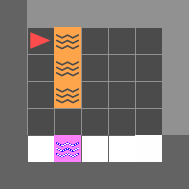

I'm playing a survival game. My mission is:

avoid the lava and get to the green goal square.

I see:
- a grey wall 1 step to my left.
- a grey wall 1 step behind me.
- red lava 1 step ahead of me.
- the green goal square 8 steps ahead of me to the right.
Moving into the lava or into walls is a very very bad idea. I must reach the goal. What action should I take? Choose among: move forward/left/right/back.

Chosen action: move right


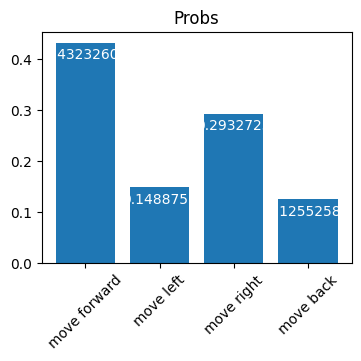

[("User:<image>I'm playing a survival game. My mission is:\n\navoid the lava and get to the green goal square.\n\nI see:\n- a grey wall 1 step to my right.\n- red lava 1 step to my left.\n- the green goal square 7 steps ahead of me to the left.\n\nMoving into the lava or into walls is a very very bad idea. I must reach the goal. What action should I take? Choose among: move forward/left/right/back. \nTo reach the green goal square, you must move forward. The lava is to your left, and the grey wall is to your right. Moving forward will allow you to avoid both the lava and the wall.<end_of_utterance>\n", <PIL.Image.Image image mode=RGB size=189x189 at 0x7F1080104B20>), ("User:<image>I'm playing a survival game. My mission is:\n\navoid the lava and get to the green goal square.\n\nI see:\n- a grey wall 1 step to my right.\n- red lava 1 step to my left.\n- the green goal square 7 steps ahead of me to the left.\n\nMoving into the lava or into walls is a very very bad idea. I must reach the 

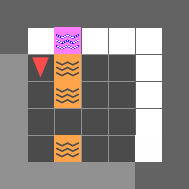

I'm playing a survival game. My mission is:

avoid the lava and get to the green goal square.

I see:
- a grey wall 1 step to my right.
- red lava 1 step to my left.
- the green goal square 7 steps ahead of me to the left.
Moving into the lava or into walls is a very very bad idea. I must reach the goal. What action should I take? Choose among: move forward/left/right/back.

Chosen action: move back


/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


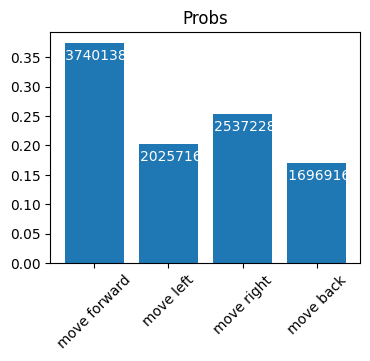

[("User:<image>I'm playing a survival game. My mission is:\n\navoid the lava and get to the green goal square.\n\nI see:\n- a grey wall 1 step ahead of me.\n- a grey wall 1 step to my left.\n- red lava 1 step to my right.\n- the green goal square 8 steps behind me.\n\nMoving into the lava or into walls is a very very bad idea. I must reach the goal. What action should I take? Choose among: move forward/left/right/back. \nTo reach the green goal square, you must avoid the lava and the grey walls. Since the grey wall is 1 step ahead of you, moving forward would take you into the lava. The grey wall to your left is also a grey wall, so moving left would not help you either. The only safe option is to move forward, as the lava is to your right.\n\nSo, the action you should take is to move forward.<end_of_utterance>\n", <PIL.Image.Image image mode=RGB size=189x189 at 0x7F10D01A78E0>), ("User:<image>I'm playing a survival game. My mission is:\n\navoid the lava and get to the green goal squar

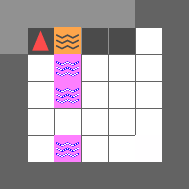

/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


I'm playing a survival game. My mission is:

avoid the lava and get to the green goal square.

I see:
- a grey wall 1 step ahead of me.
- a grey wall 1 step to my left.
- red lava 1 step to my right.
- the green goal square 8 steps behind me.
Moving into the lava or into walls is a very very bad idea. I must reach the goal. What action should I take? Choose among: move forward/left/right/back.

Chosen action: move back


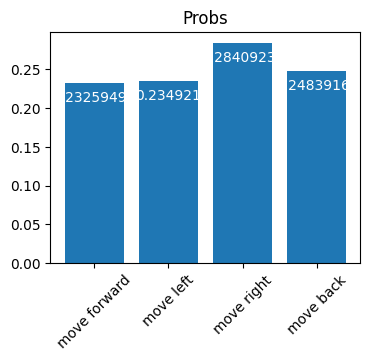

[("User:<image>I'm playing a survival game. My mission is:\n\navoid the lava and get to the green goal square.\n\nI see:\n- a grey wall 1 step to my right.\n- red lava 1 step to my left.\n- the green goal square 7 steps ahead of me to the left.\n\nMoving into the lava or into walls is a very very bad idea. I must reach the goal. What action should I take? Choose among: move forward/left/right/back. \nTo reach the green goal square, you must move forward. The lava is to your left, and the grey wall is to your right. Moving forward will allow you to avoid both the lava and the wall.<end_of_utterance>\n", <PIL.Image.Image image mode=RGB size=189x189 at 0x7F10D014BB80>), ("User:<image>I'm playing a survival game. My mission is:\n\navoid the lava and get to the green goal square.\n\nI see:\n- a grey wall 1 step to my right.\n- red lava 1 step to my left.\n- the green goal square 7 steps ahead of me to the left.\n\nMoving into the lava or into walls is a very very bad idea. I must reach the 

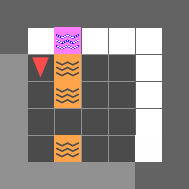

I'm playing a survival game. My mission is:

avoid the lava and get to the green goal square.

I see:
- a grey wall 1 step to my right.
- red lava 1 step to my left.
- the green goal square 7 steps ahead of me to the left.
Moving into the lava or into walls is a very very bad idea. I must reach the goal. What action should I take? Choose among: move forward/left/right/back.

Chosen action: move forward


/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


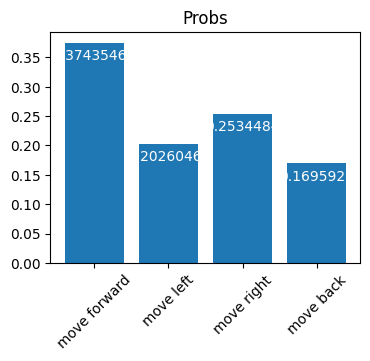

[("User:<image>I'm playing a survival game. My mission is:\n\navoid the lava and get to the green goal square.\n\nI see:\n- a grey wall 1 step to my right.\n- red lava 1 step to my left.\n- the green goal square 6 steps ahead of me to the left.\n\nMoving into the lava or into walls is a very very bad idea. I must reach the goal. What action should I take? Choose among: move forward/left/right/back. \nTo reach the green goal square, you must move forward. The lava is to your left, and the grey wall is to your right. Moving forward will allow you to avoid both the lava and the wall.<end_of_utterance>\n", <PIL.Image.Image image mode=RGB size=189x189 at 0x7F10801895A0>), ("User:<image>I'm playing a survival game. My mission is:\n\navoid the lava and get to the green goal square.\n\nI see:\n- a grey wall 1 step to my right.\n- red lava 1 step to my left.\n- the green goal square 6 steps ahead of me to the left.\n\nMoving into the lava or into walls is a very very bad idea. I must reach the 

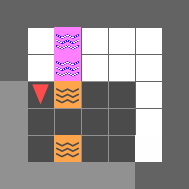

I'm playing a survival game. My mission is:

avoid the lava and get to the green goal square.

I see:
- a grey wall 1 step to my right.
- red lava 1 step to my left.
- the green goal square 6 steps ahead of me to the left.
Moving into the lava or into walls is a very very bad idea. I must reach the goal. What action should I take? Choose among: move forward/left/right/back.

Chosen action: move left


/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


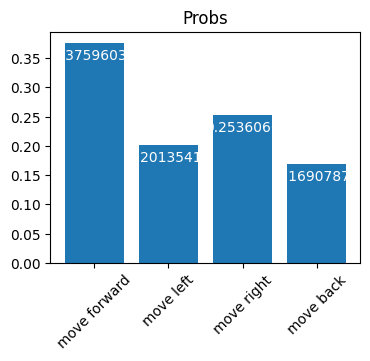

...........................................................................
.............................. EPISODE ENDED ..............................
...........................................................................


In [8]:
next_obs, infos = envs.reset(seed=seed)
next_obs = torch.Tensor(next_obs).to('cuda')
next_text_obs = infos.get('obs', [None])

max_steps = 5

step = 0
episode_step = 0

while step < max_steps:
    with torch.no_grad():
        res = agent.get_action_and_value(next_obs, 
                                         value_prompt_template=value_prompt_template,
                                         action_template=action_template,
                                         text_description=next_text_obs, 
                                         temperature=temperature,
                                         generate_actions=True,
                                         normalization_by_words=False,
                                         action_logits_from_whole_seq=False,
                                         advanced_action_matching=False)
    action, action_logits = res['action'], res['action_logits']
    action = action.cpu().numpy()

    print('-' * 30 + f" STEP {episode_step} " + '-' * 30)

    to_pil = transforms.ToPILImage()
    pil_image = to_pil(transforms.functional.invert(next_obs[0].permute(2, 0, 1)))
    display(pil_image)

    next_obs, reward, terminations, truncations, infos = envs.step(action)
    
    print(value_prompt_template.format(next_text_obs[0].strip()))
    print(f"\nChosen action: {colorama.Back.RED}{list(action_enum)[action[0]].value}")
    
    action_probs = torch.softmax(action_logits[0], dim=-1).cpu().numpy()
    plt.figure(figsize=(4, 3))        
    plt.title('Probs')
    plt.bar(range(len(action_probs)), action_probs)
    plt.xticks(range(len(action_probs)), [a.value for a in action_enum], rotation=45)
    for i, v in enumerate(action_probs):
        plt.gca().text(i, v - 0.01, str(v), color='white', verticalalignment='top', horizontalalignment='center')
    plt.show()        
    
    if terminations[0] or truncations[0]:
        s = '.' * 30 + " EPISODE ENDED " + '.' * 30
        print(colorama.Back.YELLOW + colorama.Fore.BLACK + '.' * len(s) + '\n' + s + '\n' + '.' * len(s) + colorama.Back.RESET + colorama.Fore.RESET)
        episode_step = 0
    
    next_text_obs = infos.get('obs', [None])
    next_obs = torch.Tensor(next_obs).to('cuda')
    step += 1
    episode_step += 1